# 线性模型方程：间断处的非物理振荡
$$\frac{\partial u}{\partial t}+a\frac{\partial u}{\partial x}=0, a=1,\quad u(x,0)=\begin{cases}0,&x<0.5\\1,&x\le0.5\end{cases}\quad x\in [0,1] $$
周期边界条件：$u(0)=u(1) $

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

def init(nx):
    '''
    Initialization of the linear modal equation.
    ============================================
    input: a: sound speed, 1 or -1
    output: u, x
    '''
    dx = 1 / (nx - 1)
    x = np.array([i*dx for i in range(nx)])
    u = x.copy()
    u[:int(nx/2)] = 0
    u[int(nx/2):] = 1
    temp = u[0] # periodic boundary condition
    u[0] = u[-1] 
    u[-1] = temp
    return u, x


def flux(u, a):
    '''
    Calculate the physical flux.
    ============================
    input: u: physical variable
           a: wave phase speed
    output: f = au
    '''
    fu = a * u
    return fu

## 激波捕捉格式
- 参考：李新亮，《计算流体力学》课件 (PPT) 第 4 讲
- 守恒格式
$$\frac{\partial f}{\partial x}\Big|_j=\frac{\hat{f}_{j+1/2}-\hat{f}_{j-1/2}}{\Delta x} $$
- TVD
$$\hat{f}_{j+1/2}=f_j+\phi_j(r_j)(f_{j+1}-f_j)/2\quad r_j=\frac{f_j-f_{j-1}}{f_{j+1}-f_j} $$
$$\text{Van Leer: }\phi(r)=\frac{|r|+r}{|r|+1}=\begin{cases}\frac{2r}{r+1}&r>0\\0&r\le 0 \end{cases} $$
- GVC：群速度控制格式
  - 二阶中心，快格式，波前振荡，应放到下游去
  - 二阶应分，慢格式，波后振荡，应放到上游去
  $$\hat{f}_{j+1/2}=\begin{cases}(3f_j-f_{j-1})/2&|f_j-f_{j-1}|<|f_{j+1}-f_j |\\(f_j+f_{j+1})/2&|f_j-f_{j-1} |\ge|f_{j+1}-f_j | \end{cases} $$
- MUSCL
$$f_{j+1/2}^{\rm{MUSCL3}}=f_j+\frac{s}{4}[(1-\frac{s}{3})\delta_x^-+(1+\frac{s}{3})\delta_x^+]f_j\qquad\delta^-f_j=f_j-f_{j-1},\delta^+f_j=f_{j+1}-f_j $$
$$s=\frac{2\delta^-f_j\delta^+f_j+\varepsilon}{(\delta^-f_j)^2+(\delta^+f_j)^2+\varepsilon}\qquad \varepsilon=10^{-6} $$
光滑区：$\delta^-f_j\approx\delta^+f_j\Rightarrow s\to 1\qquad f_{j+1/2}^{\rm{MUSCL3}}=(-f_{j-1}+5u_j+2u_{j+1})/6\quad\text{3阶迎风} $

非光滑区：$s\to 0\hspace{12em} f_{j+1/2}^{\rm{MUSCL3}}\to f_j\qquad\text{1阶迎风} $
- NND
$$\hat{f}_{j+1/2}=f_j+\frac{1}{2}\text{minmod}(f_j-f_{j-1},f_{j+1}-f_j) $$
- WENO5
   - 3个子模板，每个子模板4个基架点，3阶精度。按光滑度加权，都光滑逼近5阶精度(总的6个基架点)
   - 边界条件处理：用到边界外的点，模板权重设为0，效果不过，但边界降阶
   $$\hat{f}_{j+1/2}^{\rm{WENO}}=w_1\hat{f}_{j+1/2}^{(1)}+w_2\hat{f}_{j+1/2}^{(2)}+w_3\hat{f}_{j+1/2}^{(3)} $$
   $$\hat{f}_{j+1/2}^{(1)}=\frac{1}{3}f_{j-2}-\frac{7}{6}f_{j-1}+\frac{11}{6}f_j\quad \hat{f}_{j+1/2}^{(2)}=-\frac{1}{6}f_{j-1}+\frac{5}{6}f_{j}+\frac{1}{3}f_{j+1}$$
   $$\hat{f}_{j+1/2}^{(3)}=\frac{1}{3}f_{j}+\frac{5}{6}f_{j+1}-\frac{1}{6}f_{j+2}\qquad w_k=\frac{\alpha_k}{\alpha_1+\alpha_2+\alpha_3} $$
   $$\alpha_k=\frac{C_k}{(\varepsilon+IS_k)^2},\varepsilon=10^{-6}\qquad C_1=\frac{1}{10},C_2=\frac{6}{10},C_3=\frac{3}{10} $$
   $$IS_1=\frac{1}{4}(f_{j-2}-4f_{j-1}+3f_j)^2+\frac{13}{12}(f_{j-2}-2f_{j-1}+f_j)^2 $$
   $$IS_2=\frac{1}{4}(f_{j-1}-f_{j+1})^2+\frac{13}{12}(f_{j-1}-2f_{j}+f_{j+1})^2 $$
   $$IS_3=\frac{1}{4}(3f_{j}-4f_{j+1}+f_{j+2})^2+\frac{13}{12}(f_{j}-2f_{j+1}+f_{j+2})^2 $$

In [4]:
def van_leer_limiter(dm, dp): # delta^-, delta^+
    '''
    input: dm: delta^-, f_j - f_{j-1}
           dp: delta^+, f_{j+1} - f_j
    '''
    if isinstance(dm, np.ndarray): # array
        len = dm.shape[0]
        phi = np.zeros(dm.size)
        for i in range(len):
            if dm[i] * dp[i] > 0:
                r = dm[i] / dp[i]
                phi[i] = 2*r/(r+1)
            else:
                phi[i] = 0
    else:
        if dm * dp > 0:
            r = dm / dp
            phi = 2 * r / (r + 1)
        else:
            phi = 0
    return phi


def TVD_van_leer_pos(f):
    '''
    Calculate difference of numerical flux for positive wave speed with Van Leer Type TVD scheme.
    '''
    nx = f.shape[0]
    fp = np.zeros(f.size); fm = fp.copy()

    fp[0] = f[0] + van_leer_limiter(0, f[1]-f[0])*(f[1]-f[0])/2; fp[nx-1] = f[nx-1] # f[nx]=f[nx-1]
    fp[1:nx-1] = f[1:nx-1] + van_leer_limiter(f[1:nx-1]-f[:nx-2],f[2:]-f[1:nx-1])*(f[2:]-f[1:nx-1])/2

    fm[0] = f[0]; fm[1] = f[0] + van_leer_limiter(0,f[1]-f[0])*(f[1]-f[0])/2
    fm[2:] = f[1:nx-1] + van_leer_limiter(f[1:nx-1]-f[:nx-2],f[2:]-f[1:nx-1])*(f[2:]-f[1:nx-1])/2

    df = fp-fm
    return df


def TVD_van_leer_neg(f):
    '''
    Calculate difference of numerical flux for negative wave speed with Van Leer Type TVD scheme.
    '''
    nx = f.shape[0]
    fp = np.zeros(f.size); fm = fp.copy()

    fp[nx-1] = f[nx-1]; fp[nx-2] = f[nx-1] + van_leer_limiter(0, f[nx-2]-f[nx-1])*(f[nx-2]-f[nx-1])/2 # f[nx]=f[nx-1]
    fp[:nx-2] = f[1:nx-1] + van_leer_limiter(f[1:nx-1]-f[2:],f[:nx-2]-f[1:nx-1])*(f[:nx-2]-f[1:nx-1])/2

    fm[0] = f[0]; fm[nx-1] = f[nx-1] + van_leer_limiter(0,f[nx-2]-f[nx-1])*(f[nx-2]-f[nx-1])/2
    fm[1:nx-1] = f[1:nx-1] + van_leer_limiter(f[1:nx-1]-f[2:],f[:nx-2]-f[1:nx-1])*(f[:nx-2]-f[1:nx-1])/2

    df = fp-fm
    return df

In [5]:
def GVC_pos(f):
    '''
    Calculate difference of GVC numerical flux for positive wave speed.
    ================================================================
    output: f_{j+1/2} - f_{j-1/2}
    '''
    nx = f.shape[0]
    fp = np.zeros(f.size); # f_{j+1/2} 
    fm = fp.copy()         # f_{j-1/2}

    fp[0] = f[0]; fp[nx-1] = f[nx-1]
    for i in range(1, nx-1):
        if np.abs(f[i]-f[i-1]) < np.abs(f[i+1]-f[i]):
            fp[i] = (3*f[i]-f[i-1])/2
        else:
            fp[i] = (f[i]+f[i+1])/2

    fm[0] = f[0]; fm[1] = f[0]
    for i in range(2, nx):
        if np.abs(f[i-1]-f[i-2]) < np.abs(f[i]-f[i-1]):
            fm[i] = (3*f[i-1]-f[i-2])/2
        else:
            fm[i] = (f[i-1]+f[i])/2

    df = fp - fm
    return df


def GVC_neg(f):
    '''
    Calculate difference of GVC numerical flux for negative wave speed.
    ================================================================
    output: f_{j+1/2} - f_{j-1/2}
    '''
    nx = f.shape[0]
    fp = np.zeros(f.size); # f_{j+1/2} 
    fm = fp.copy()         # f_{j-1/2}

    fp[nx-1] = f[nx-1]; fp[nx-2] = f[nx-1]
    for i in range(nx-2):
        if np.abs(f[i+1]-f[i+2]) < np.abs(f[i]-f[i+1]):
            fp[i] = (3*f[i+1]-f[i+2])/2
        else:
            fp[i] = (f[i+1]+f[i])/2

    fm[0] = f[0]; fm[nx-1] = f[nx-1]
    for i in range(1, nx-1):
        if np.abs(f[i]-f[i+1]) < np.abs(f[i-1]-f[i]):
            fm[i] = (3*f[i]-f[i+1])/2
        else:
            fm[i] = (f[i]+f[i-1])/2

    df = fp - fm
    return df

In [6]:
def smooth_deg(dm, dp): # delta^-, delta^+
    epsilon = 1e-6
    s = (2*dm*dp+epsilon)/(dm*dm+dp*dp+epsilon)
    return s


def MUSCL_pos(f):
    nx = f.shape[0]
    fp = np.zeros(f.size); # f_{j+1/2}
    fm = fp.copy()         # f_{j-1/2}
    delta_p = fp.copy()  # f_{j+1}-f_j
    delta_m = fp.copy()  # f_j-f_{j-1}
    delta_mm = fp.copy() # f_{j-1}-f_{j-2}
    delta_p[nx-1] = 0; delta_p[:nx-1] = f[1:]-f[:nx-1]
    delta_m[0] = 0; delta_m[1:] = f[1:]-f[:nx-1]
    s = smooth_deg(delta_m, delta_p)
    fp = f + s/4*((1-s/3)*delta_m+(1+s/3)*delta_p)

    delta_mm[:2] = 0; delta_mm[2:] = f[1:nx-1]-f[:nx-2]
    s = smooth_deg(delta_mm, delta_m)
    fm[0] = f[0] + s[0]/4*((1-s[0]/3)*delta_mm[0]+(1+s[0]/3)*delta_m[0])
    fm[1:] = f[:nx-1] + s[1:]/4*((1-s[1:]/3)*delta_mm[1:]+(1+s[1:]/3)*delta_m[1:])

    df = fp - fm
    return df


def MUSCL_neg(f):
    nx = f.shape[0]
    fp = np.zeros(f.size); # f_{j+1/2}
    fm = fp.copy()         # f_{j-1/2}
    delta_pp = fp.copy() # f_{j+1}-f_{j+2}
    delta_p = fp.copy()  # f_j-f_{j+1}
    delta_m = fp.copy()  # f_{j-1}-f_j
    delta_m[0] = 0; delta_m[1:] = f[:nx-1]-f[1:]
    delta_p[nx-1] = 0; delta_p[:nx-1] = f[:nx-1]-f[1:]
    delta_pp[nx-2:] = 0; delta_pp[:nx-2] = f[1:nx-1]-f[2:]
    s = smooth_deg(delta_p, delta_m)
    fm = f + s/4*((1-s/3)*delta_p+(1+s/3)*delta_m)

    s = smooth_deg(delta_pp, delta_p)
    fp[nx-1] = f[-1] + s[-1]/4*((1-s[-1]/3)*delta_pp[-1]+(1+s[-1]/3)*delta_p[-1])
    fp[:-1] = f[1:] + s[:-1]/4*((1-s[:-1]/3)*delta_pp[:-1]+(1+s[:-1]/3)*delta_p[:-1])

    df = fp - fm
    return df

In [7]:
def minmod(a, b): # 同号(不为0)取绝对值小的，否则取0
    if isinstance(a, np.ndarray): # a, b为一维数组
        len = a.shape[0]
        temp = np.zeros(a.size)
        for i in range(len):
            if a[i] * b[i] > 0:
                if np.abs(a[i]) > np.abs(b[i]):
                    temp[i] = b[i]
                else:
                    temp[i] = a[i]
            else:
                temp[i] = 0
    else:
        if a * b > 0:
            if np.abs(a) > np.abs(b):
                temp = b
            else:
                temp = a
        else:
            temp = 0
    return temp


def NND_pos(f):
    '''
    Calculate difference of NND numerical flux for positive wave speed.
    ================================================================
    output: f_{j+1/2} - f_{j-1/2}
    '''
    nx = f.shape[0]
    fp = np.zeros(f.size) # f_{j+1/2}
    fm = np.zeros(f.size) # f_{j-1/2}
    fp[0] = f[0] + 1/2*minmod(0, f[1]-f[0])
    fp[nx-1] = f[nx-1] + 1/2*minmod(f[nx-1]-f[nx-2], 0)
    fp[1:nx-1] = f[1:nx-1] + 1/2*minmod(f[1:nx-1]-f[0:nx-2], f[2:]-f[1:nx-1])

    fm[0] = f[0] + 1/2*minmod(0, 0) 
    fm[1] = f[0] + 1/2*minmod(0, f[1]-f[0])
    fm[2:] = f[1:nx-1] + 1/2*minmod(f[1:nx-1]-f[0:nx-2], f[2:]-f[1:nx-1])
    df = fp - fm
    return df


def NND_neg(f):
    '''
    Calculate difference of NND numerical flux for negative wave speed.
    '''
    nx = f.shape[0]
    fp = np.zeros(f.size) # f_{j+1/2}
    fm = np.zeros(f.size) # f_{j-1/2}
    fp[nx-1] = f[0] + 1/2*minmod(0, 0)
    fp[nx-2] = f[nx-1] + 1/2*minmod(0, f[nx-2]-f[nx-1])
    fp[:nx-2] = f[1:nx-1] + 1/2*minmod(f[1:nx-1]-f[2:], f[:nx-2]-f[1:nx-1])

    fm[0] = f[0] + 1/2*minmod(f[0]-f[1], 0) 
    fm[nx-1] = f[nx-1] + 1/2*minmod(0, f[nx-2]-f[nx-1])
    fm[1:nx-1] = f[1:nx-1] + 1/2*minmod(f[1:nx-1]-f[2:], f[:nx-2]-f[1:nx-1])
    df = fp - fm
    return df

In [13]:
def WENO5_pos(f):
    epsilon = 1e-6
    C1 = 1/10; C2 = 6/10; C3 = 3/10
    f1 = np.zeros(f.size); f2 = f1.copy(); f3 = f1.copy() # 子模板
    IS1 = f1.copy(); IS2 = f1.copy(); IS3 = f1.copy()
    fp = f1.copy() # f_{j+1/2}
    fm = f1.copy() # f_{j-1/2}

    # f_{j+1/2}
    f1[0] = f[0]; f1[1] = -5/6*f[0] + 11/6*f[1]
    f1[2:] = 1/3*f[:-2] - 7/6*f[1:-1] + 11/6*f[2:]
    f2[0] = 2/3*f[0] + 1/3*f[1]; f2[-1] = -1/6*f[-2] + 7/6*f[-1]
    f2[1:-1] = -1/6*f[:-2] + 5/6*f[1:-1] + 1/3*f[2:]
    f3[-2] = 1/3*f[-2] + 2/3*f[-1]; f3[-1] = f[-1]
    f3[:-2] = 1/3*f[:-2] + 5/6*f[1:-1] - 1/6*f[2:]
    IS1[0] = 0; IS1[1] = 1/4*(-3*f[0]+3*f[1])**2 + 13/12*(-f[0]+f[1])**2
    IS1[2:] = 1/4*(f[:-2]-4*f[1:-1]+3*f[2:])**2 + 13/12*(f[:-2]-2*f[1:-1]+f[2:])**2
    IS2[0] = 1/4*(f[0]-f[1])**2+13/12*(-f[0]+f[1])**2
    IS2[-1] = 1/4*(f[-2]-f[-1])**2+13/12*(f[-2]-f[-1])**2
    IS2[1:-1] = 1/4*(f[:-2]-f[2:])**2 + 13/12*(f[:-2]-2*f[1:-1]+f[2:])**2
    IS3[-1] = 0; IS3[-2] = 1/4*(3*f[-2]-3*f[-1])**2+13/12*(f[-2]-f[-1])**2
    IS3[:-2] = 1/4*(3*f[:-2]-4*f[1:-1]+f[2:])**2 + 13/12*(f[:-2]-2*f[1:-1]+f[2:])**2
    alpha1 = C1/(epsilon+IS1)**2; alpha1[:2] = 0
    alpha2 = C2/(epsilon+IS2)**2; alpha2[0] = 0; alpha2[-1] = 0
    alpha3 = C3/(epsilon+IS3)**2; alpha3[-2:] = 0
    w1 = alpha1/(alpha1+alpha2+alpha3) 
    w2 = alpha2/(alpha1+alpha2+alpha3) 
    w3 = alpha3/(alpha1+alpha2+alpha3)
    fp = w1*f1 + w2*f2 + w3*f3
    
    # f_{j-1/2}
    f1[0] = f[0]; f1[1] = f[0]; f[2] = -5/6*f[0] + 11/6*f[1]
    f1[3:] = 1/3*f[:-3] - 7/6*f[1:-2] + 11/6*f[2:-1]
    f2[0] = f[0]; f[1] = 2/3*f[0] + 1/3*f[1]
    f2[2:] = -1/6*f[:-2] + 5/6*f[1:-1] + 1/3*f[2:]
    f3[0] = 7/6*f[0] - 1/6*f[1]; f3[-1] = 1/3*f[-2] + 2/3*f[-1]
    f3[1:-1] = 1/3*f[:-2] + 5/6*f[1:-1] - 1/6*f[2:]
    IS1[0:2] = 0; IS1[2] = 1/4*(-3*f[0]+3*f[1])**2 + 13/12*(-f[0]+f[1])**2
    IS1[3:] = 1/4*(f[:-3]-4*f[1:-2]+3*f[2:-1])**2 + 13/12*(f[:-3]-2*f[1:-2]+f[2:-1])**2
    IS2[0] = 0; IS2[1] = 1/4*(f[0]-f[1])**2+13/12*(-f[0]+f[1])**2
    IS2[2:] = 1/4*(f[:-2]-f[2:])**2 + 13/12*(f[:-2]-2*f[1:-1]+f[2:])**2
    IS3[0] = 1/4*(-f[0]+f[1])**2+13/12*(-f[0]+f[1])**2
    IS3[-1] = 1/4*(3*f[-2]-3*f[-1])**2+13/12*(f[-2]-f[-1])**2
    IS3[1:-1] = 1/4*(3*f[:-2]-4*f[1:-1]+f[2:])**2 + 13/12*(f[:-2]-2*f[1:-1]+f[2:])**2
    alpha1 = C1/(epsilon+IS1)**2; alpha1[:3] = 0
    alpha2 = C2/(epsilon+IS2)**2; alpha2[:2] = 0
    alpha3 = C3/(epsilon+IS3)**2; alpha3[0] = 0; alpha3[-1] = 0
    w1 = alpha1/(alpha1+alpha2+alpha3)
    w2 = alpha2/(alpha1+alpha2+alpha3)
    w3 = alpha3/(alpha1+alpha2+alpha3)
    fm = w1*f1 + w2*f2 + w3*f3; fm[0] = fp[0] # order reduction, 0/0=nan

    df = fp - fm
    return df


def WENO5_neg(f):
    epsilon = 1e-6
    C1 = 1/10; C2 = 6/10; C3 = 3/10
    f1 = np.zeros(f.size); f2 = f1.copy(); f3 = f1.copy() # 子模板
    IS1 = f1.copy(); IS2 = f1.copy(); IS3 = f1.copy()
    fp = f1.copy() # f_{j+1/2}
    fm = f1.copy() # f_{j-1/2}

    # f_{j-1/2}
    f1[-1] = f[-1]; f1[-2] = -5/6*f[-1] + 11/6*f[-2]
    f1[:-2] = 1/3*f[2:] - 7/6*f[1:-1] + 11/6*f[:-2]
    f2[0] = 7/6*f[0] - 1/6*f[1]; f2[-1] =1/3*f[-2] + 2/3*f[-1]
    f2[1:-1] = 1/3*f[:-2] + 5/6*f[1:-1] - 1/6*f[2:]
    f3[1] = 1/3*f[1] + 2/3*f[0]; f3[0] = f[0]
    f3[2:] = -1/6*f[:-2] + 5/6*f[1:-1] + 1/3*f[2:]
    IS1[-1] = 0; IS1[-2] = 1/4*(-3*f[-1]+3*f[-2])**2 + 13/12*(-f[-1]+f[-2])**2
    IS1[:-2] = 1/4*(3*f[:-2]-4*f[1:-1]+f[2:])**2 + 13/12*(f[:-2]-2*f[1:-1]+f[2:])**2
    IS2[0] = 1/4*(f[0]-f[1])**2+13/12*(-f[0]+f[1])**2
    IS2[-1] = 1/4*(f[-2]-f[-1])**2+13/12*(f[-2]-f[-1])**2
    IS2[1:-1] = 1/4*(f[:-2]-f[2:])**2 + 13/12*(f[:-2]-2*f[1:-1]+f[2:])**2
    IS3[0] = 0; IS3[1] = 1/4*(3*f[1]-3*f[0])**2+13/12*(f[1]-f[0])**2
    IS3[2:] = 1/4*(f[:-2]-4*f[1:-1]+3*f[2:])**2 + 13/12*(f[:-2]-2*f[1:-1]+f[2:])**2
    alpha1 = C1/(epsilon+IS1)**2; alpha1[-2:] = 0
    alpha2 = C2/(epsilon+IS2)**2; alpha2[0] = 0; alpha2[-1] = 0
    alpha3 = C3/(epsilon+IS3)**2; alpha3[:2] = 0
    w1 = alpha1/(alpha1+alpha2+alpha3) 
    w2 = alpha2/(alpha1+alpha2+alpha3) 
    w3 = alpha3/(alpha1+alpha2+alpha3)
    fm = w1*f1 + w2*f2 + w3*f3
    
    # f_{j+1/2}
    f1[-2:] = f[-1]; f[-3] = -5/6*f[-1] + 11/6*f[-2]
    f1[:-3] = 1/3*f[3:] - 7/6*f[2:-1] + 11/6*f[1:-2]
    f2[-1] = f[-1]; f[-2] = 2/3*f[-1] + 1/3*f[-2]
    f2[:-2] = -1/6*f[2:] + 5/6*f[1:-1] + 1/3*f[:-2]
    f3[-1] = 7/6*f[-1] - 1/6*f[-2]; f3[0] = 1/3*f[1] + 2/3*f[0]
    f3[1:-1] = 1/3*f[2:] + 5/6*f[1:-1] - 1/6*f[:-2]
    IS1[-2:] = 0; IS1[-3] = 1/4*(-3*f[-1]+3*f[-2])**2 + 13/12*(-f[-1]+f[-2])**2
    IS1[:-3] = 1/4*(f[3:]-4*f[2:-1]+3*f[1:-2])**2 + 13/12*(f[3:]-2*f[2:-1]+f[1:-2])**2
    IS2[-1] = 0; IS2[-2] = 1/4*(f[-1]-f[-2])**2+13/12*(-f[-1]+f[-2])**2
    IS2[:-2] = 1/4*(f[:-2]-f[2:])**2 + 13/12*(f[:-2]-2*f[1:-1]+f[2:])**2
    IS3[-1] = 1/4*(-f[-1]+f[-2])**2+13/12*(-f[-1]+f[-2])**2
    IS3[0] = 1/4*(3*f[1]-3*f[0])**2+13/12*(f[1]-f[0])**2
    IS3[1:-1] = 1/4*(f[:-2]-4*f[1:-1]+3*f[2:])**2 + 13/12*(f[:-2]-2*f[1:-1]+f[2:])**2
    alpha1 = C1/(epsilon+IS1)**2; alpha1[-3:] = 0
    alpha2 = C2/(epsilon+IS2)**2; alpha2[-2:] = 0
    alpha3 = C3/(epsilon+IS3)**2; alpha3[0] = 0; alpha3[-1] = 0
    w1 = alpha1/(alpha1+alpha2+alpha3)
    w2 = alpha2/(alpha1+alpha2+alpha3)
    w3 = alpha3/(alpha1+alpha2+alpha3)
    fp = w1*f1 + w2*f2 + w3*f3; fp[-1] = fm[-1] # order reduction, 0/0=nan

    df = fp - fm
    return df

## 时间推进方法 
### 显格式：3阶Runge-Kutta(TVD)
$$\frac{\partial U}{\partial t}=Q(U) $$
$$\begin{cases}U^{(1)}=&U^n+\Delta tQ(U^n)\\U^{(2)}=&\frac{3}{4}U^n+\frac{1}{4}U^{(1)}+\frac{1}{4}\Delta tQ(U^{(1)})\\U^{n+1}=&\frac{1}{3}U^n+\frac{2}{3}U^{(2)}+\frac{2}{3}\Delta tQ(U^{(2)}) \end{cases} $$

In [9]:
def runge_kutta(un, u, df, dt, dx, order):
    '''
    input: un: physical variable at the previous step
    '''
    du = -df/dx
    if order == 1:
        u = un + dt * du
    elif order == 2:
        u = 3/4*un + 1/4*u + 1/4*dt*du
    elif order == 3:
        u = 1/3*un + 2/3*u + 2/3*dt*du
    return u

time step = 225 and total time = 0.6000000000000004


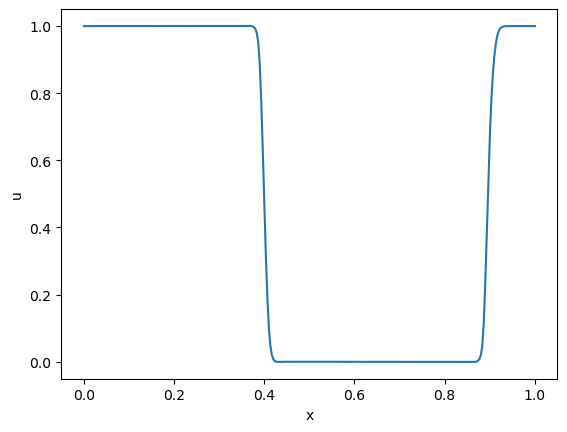

In [14]:
nx = 301
a = -1
CFL = 0.8
t = 0
tstep = 0
t_end = 0.6
TVD = 1; GVC = 2; MUSCL = 3; NND = 4; WENO5 = 5
scheme_type = 5

u, x = init(nx)
dx = x[1] - x[0]
dt = CFL * dx / np.abs(a)

while t < t_end:
    un = u
    for order in range(1,4):
        fu = flux(u, a)
        if scheme_type == TVD:
            if a > 0:
                df = TVD_van_leer_pos(fu)
            elif a < 0:
                df = TVD_van_leer_neg(fu)
        elif scheme_type == GVC:
            if a > 0:
                df = GVC_pos(fu)
            elif a < 0:
                df = GVC_neg(fu)
        elif scheme_type == MUSCL:
            if a > 0:
                df = MUSCL_pos(fu)
            elif a < 0:
                df = MUSCL_neg(fu)
        elif scheme_type == NND:
            if a > 0:
                df = NND_pos(fu)
            elif a < 0:
                df = NND_neg(fu)
        elif scheme_type == WENO5:
            if a > 0:
                df = WENO5_pos(fu)
            elif a < 0:
                df = WENO5_neg(fu)
        u = runge_kutta(un, u, df, dt, dx, order)
        temp = u[0] # periodic boundary condition
        u[0] = u[-1] 
        u[-1] = temp
        if order == 3: # Runge-Kutta complete
            t += dt
            tstep += 1
            print('time step = {} and total time = {}'.format(tstep, t))

    plt.plot(x, u); plt.xlabel('x'); plt.ylabel('u')
    plt.pause(0.05)
    display.clear_output(wait=True)


In [ ]:
tmp = np.array([1,2,3,4,5,6])
tmp[-2:]

array([5, 6])